In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0 : print('Available GPUs: {}'.format(gpus))
else             : print('!!! No GPUs found !!!')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]


X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


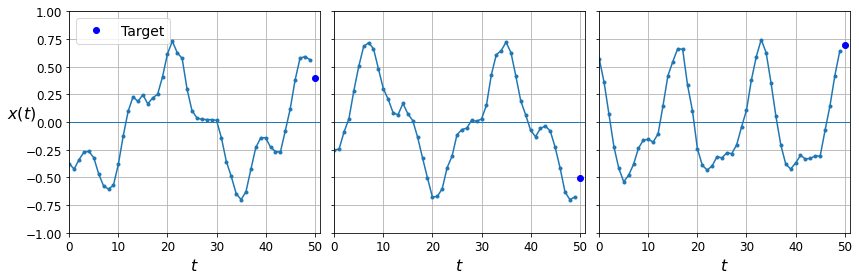

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

Metal device set to: Apple M1 Pro


2021-12-19 17:44:11.156745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-19 17:44:11.157058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0.020211367

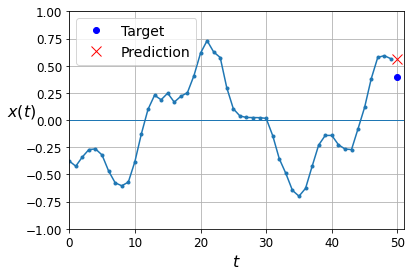

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
  1/219 [..............................] - ETA: 32s - loss: 0.2185

2021-12-19 17:44:16.026876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 17:44:16.029912: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-19 17:44:16.129437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 1s 3ms/step - loss: 0.0706 - val_loss: 0.0296
Epoch 2/20
 18/219 [=>............................] - ETA: 0s - loss: 0.0257

2021-12-19 17:44:16.850045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 1s 3ms/step - loss: 0.0189 - val_loss: 0.0128
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0100 - val_loss: 0.0082
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 11/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 12/

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0035


0.003546462394297123

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,batch_size=256,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


2021-12-19 17:45:07.561959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.5801

2021-12-19 17:45:27.214532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 21s 721ms/step - loss: 0.5801 - val_loss: 0.4868
Epoch 2/20
28/28 [==============================] - 21s 744ms/step - loss: 0.3648 - val_loss: 0.2976
Epoch 3/20
28/28 [==============================] - 21s 765ms/step - loss: 0.2817 - val_loss: 0.2610
Epoch 4/20
28/28 [==============================] - 20s 733ms/step - loss: 0.2464 - val_loss: 0.2312
Epoch 5/20
28/28 [==============================] - 21s 745ms/step - loss: 0.2130 - val_loss: 0.1965
Epoch 6/20
28/28 [==============================] - 23s 835ms/step - loss: 0.1792 - val_loss: 0.1665
Epoch 7/20
28/28 [==============================] - 21s 744ms/step - loss: 0.1545 - val_loss: 0.1490
Epoch 8/20
28/28 [==============================] - 22s 772ms/step - loss: 0.1430 - val_loss: 0.1460
Epoch 9/20
28/28 [==============================] - 21s 758ms/step - loss: 0.1407 - val_loss: 0.1444
Epoch 10/20
28/28 [==============================] - 21s 738ms/step - loss: 0.1407 - val_loss: 0.1493


In [13]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10, batch_size=256,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


2021-12-19 17:53:41.676782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.0649

2021-12-19 17:54:30.744475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 51s 2s/step - loss: 0.0649 - val_loss: 0.0220
Epoch 2/10
28/28 [==============================] - 51s 2s/step - loss: 0.0156 - val_loss: 0.0115
Epoch 3/10
28/28 [==============================] - 55s 2s/step - loss: 0.0096 - val_loss: 0.0079
Epoch 4/10
28/28 [==============================] - 53s 2s/step - loss: 0.0072 - val_loss: 0.0063
Epoch 5/10
28/28 [==============================] - 53s 2s/step - loss: 0.0058 - val_loss: 0.0052
Epoch 6/10
28/28 [==============================] - 53s 2s/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/10
28/28 [==============================] - 53s 2s/step - loss: 0.0044 - val_loss: 0.0040
Epoch 8/10
28/28 [==============================] - 55s 2s/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/10
28/28 [==============================] - 53s 2s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/10
28/28 [==============================] - 54s 2s/step - loss: 0.0035 - val_loss: 0.0033


In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 12s 183ms/step - loss: 0.0033


0.003318969625979662

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [49]:
X_valid[0][1]

array([-0.46066475], dtype=float32)

In [50]:
Y_valid[0][1]

array([-0.43787631, -0.33716959, -0.24441192, -0.3146477 , -0.30957073,
       -0.43265647, -0.55953503, -0.56325197, -0.63630873, -0.46796456])

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=10, batch_size=256,
                    validation_data=(X_valid, Y_valid))

Epoch 1/10


2021-12-19 18:08:28.633870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1027 - last_time_step_mse: 0.0968

2021-12-19 18:09:24.537791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 58s 2s/step - loss: 0.1027 - last_time_step_mse: 0.0968 - val_loss: 0.0534 - val_last_time_step_mse: 0.0437
Epoch 2/10
28/28 [==============================] - 69s 2s/step - loss: 0.0485 - last_time_step_mse: 0.0376 - val_loss: 0.0452 - val_last_time_step_mse: 0.0334
Epoch 3/10
13/28 [============>.................] - ETA: 28s - loss: 0.0451 - last_time_step_mse: 0.0331

KeyboardInterrupt: 

In [58]:
model.save('./simple_rnn/')

2021-12-19 13:29:51.277675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./simple_rnn/assets


In [19]:
np.random.seed(42)
tf.random.set_seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# optimizer=keras.optimizers.Adam(learning_rate=0.01)
# optimizer="adam"
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


2021-12-19 18:12:00.621942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:00.723084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:00.785279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:00.869119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:00.985922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - ETA: 0s - loss: 0.1262 - last_time_step_mse: 0.1364

2021-12-19 18:12:07.357270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:07.394802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 18:12:07.454262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 8s 33ms/step - loss: 0.1262 - last_time_step_mse: 0.1364 - val_loss: 0.1288 - val_last_time_step_mse: 0.1459
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.1235 - last_time_step_mse: 0.1425 - val_loss: 0.1204 - val_last_time_step_mse: 0.1431
Epoch 3/20
219/219 [==============================] - 7s 30ms/step - loss: 0.1246 - last_time_step_mse: 0.1442 - val_loss: 0.1253 - val_last_time_step_mse: 0.1448
Epoch 4/20
 75/219 [=========>....................] - ETA: 3s - loss: 0.1247 - last_time_step_mse: 0.1436

KeyboardInterrupt: 

In [44]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.1206 - last_time_step_mse: 0.1515


[0.12062693387269974, 0.15148590505123138]

In [56]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

2021-12-19 13:28:52.635957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


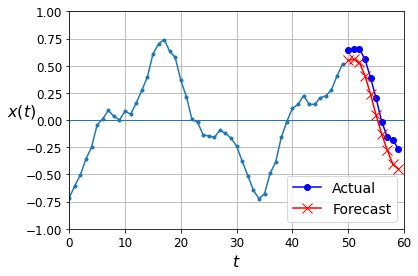

In [57]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()